# Spatiotemporal Traffic Analysis in San Diego  
**Authors**: [Bethany Sioson, Mandie Hankinson, Mariana Khoshaba, Diego Angulo Nevarez] 
**Course**: STAT 596 - Spatiotemporal Analysis  

In [3]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import folium
from folium.plugins import HeatMap
import plotly.express as px

# Load data
adt_df = pd.read_csv('/Users/betho/Downloads/traffic_counts_datasd.csv')  # Replace with your file path
print(adt_df.head())  # Check the first 5 rows

           id street_name             limits northbound_count  \
0  01AV018207       01 AV      A ST - ASH ST            18010   
1  01AV015210       01 AV      A ST - ASH ST            20060   
2  01AV018213       01 AV      A ST - ASH ST            19597   
3  01AV007721       01 AV      A ST - ASH ST            10640   
4  01AV088812       01 AV  ASH ST - BEECH ST             2298   

   southbound_count  eastbound_count  westbound_count  total_count  file_no  \
0               NaN              NaN              NaN        18010  0182-07   
1               NaN              NaN              NaN        20060  0152-10   
2               NaN              NaN              NaN        19597  0182-13   
3               NaN              NaN              NaN        10640  0077-21   
4               NaN              NaN              NaN         2298  0888-12   

            date_count  
0  2007-03-13 00:00:00  
1  2010-03-18 00:00:00  
2  2013-03-12 00:00:00  
3  2021-03-10 00:00:00  
4  2012-1

# Data Cleaning

In [4]:
# Convert date columns to datetime if they exist
date_cols = [col for col in adt_df.columns if 'date' in col.lower()]
for col in date_cols:
    adt_df[col] = pd.to_datetime(adt_df[col])
    
# Handle missing values if any
print("\nMissing values per column:")
print(adt_df.isnull().sum())

# Convert date_count to datetime 
adt_df['date_count'] = pd.to_datetime(adt_df['date_count'], errors='coerce')

# Convert northbound_count from string to numeric (since it's 'object')
adt_df['northbound_count'] = pd.to_numeric(adt_df['northbound_count'], errors='coerce')

# Drop rows where total_count is 0 
adt_df = adt_df[adt_df['total_count'] > 0]


Missing values per column:
id                     0
street_name            0
limits                 0
northbound_count    6881
southbound_count    6849
eastbound_count     7374
westbound_count     7390
total_count            0
file_no                0
date_count             2
dtype: int64


In [5]:
# Initial data exploration
print("Data shape:", adt_df.shape)
print("\nColumn info:")
print(adt_df.info())
print("\nSummary statistics:")
print(adt_df.describe())

Data shape: (13660, 10)

Column info:
<class 'pandas.core.frame.DataFrame'>
Index: 13660 entries, 0 to 13690
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                13660 non-null  object        
 1   street_name       13660 non-null  object        
 2   limits            13660 non-null  object        
 3   northbound_count  6808 non-null   float64       
 4   southbound_count  6841 non-null   float64       
 5   eastbound_count   6317 non-null   float64       
 6   westbound_count   6301 non-null   float64       
 7   total_count       13660 non-null  int64         
 8   file_no           13660 non-null  object        
 9   date_count        13659 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 1.1+ MB
None

Summary statistics:
       northbound_count  southbound_count  eastbound_count  westbound_count  \
count       6808.000000 

# Basic Visualization

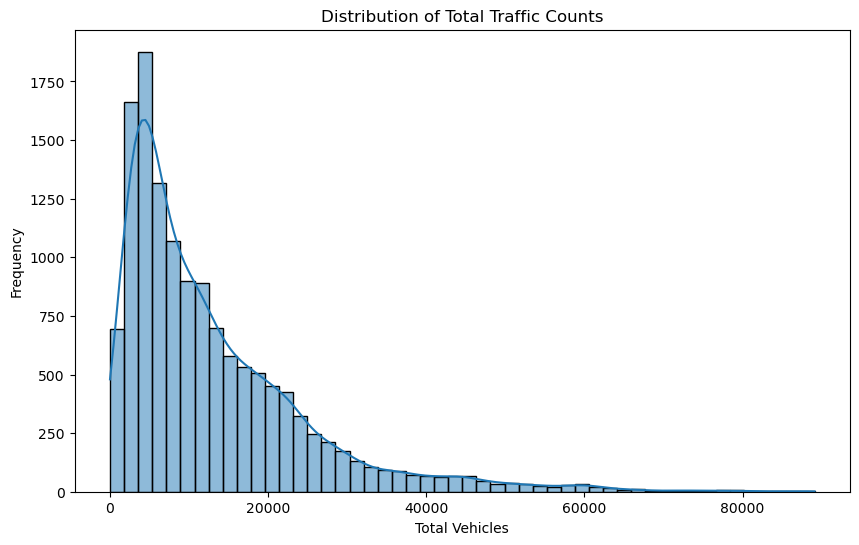

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(adt_df['total_count'], bins=50, kde=True)
plt.title('Distribution of Total Traffic Counts')
plt.xlabel('Total Vehicles')
plt.ylabel('Frequency')
plt.show()

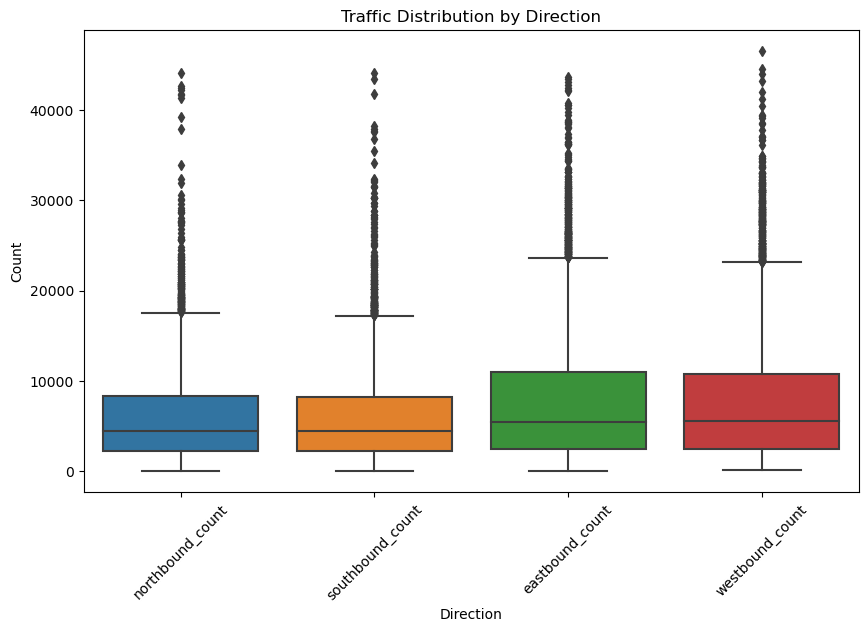

In [7]:
# Melt data for directional counts
direction_cols = ['northbound_count', 'southbound_count', 'eastbound_count', 'westbound_count']
df_directions = adt_df[direction_cols].melt(var_name='Direction', value_name='Count')

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_directions, x='Direction', y='Count')
plt.title('Traffic Distribution by Direction')
plt.xticks(rotation=45)
plt.show()

# Time-Series Analysis

In [8]:
#Extract year and month:
adt_df['date_count'] = pd.to_datetime(adt_df['date_count'])  # Ensure datetime
adt_df['year'] = adt_df['date_count'].dt.year  # Use .dt, not .adt_dt
adt_df['month'] = adt_df['date_count'].dt.month

# Drop rows with missing dates (if needed)
adt_df = adt_df.dropna(subset=['date_count'])

In [9]:
# Convert columns to correct dtypes
adt_df['date_count'] = pd.to_datetime(adt_df['date_count'])
adt_df['northbound_count'] = pd.to_numeric(adt_df['northbound_count'], errors='coerce')

# Extract time features
adt_df['year'] = adt_df['date_count'].dt.year
adt_df['month'] = adt_df['date_count'].dt.month

# Drop rows with NaN in key columns
adt_df_clean = adt_df.dropna(subset=['year', 'total_count'])

In [10]:
from scipy.stats import linregress

def safe_linregress(df_group):
    """Handle edge cases where regression fails."""
    if len(df_group) < 2:
        return pd.Series({
            'growth_rate': np.nan,
            'intercept': np.nan,
            'r_squared': np.nan
        })
    try:
        slope, intercept, r_value, _, _ = linregress(
            x=df_group['year'],
            y=df_group['total_count']
        )
        return pd.Series({
            'growth_rate': slope,
            'intercept': intercept,
            'r_squared': r_value**2
        })
    except:
        return pd.Series({
            'growth_rate': np.nan,
            'intercept': np.nan,
            'r_squared': np.nan
        })

# Apply to cleaned data
annual_traffic = adt_df_clean.groupby(['street_name', 'year'])['total_count'].mean().reset_index()
growth_rates = annual_traffic.groupby('street_name').apply(safe_linregress).reset_index()

# Drop NaN results (optional)
growth_rates = growth_rates.dropna()

In [11]:
# Consider weighting by number of observations per year
annual_traffic = (adt_df.groupby(['street_name', 'year'])
                 .agg({'total_count': ['mean', 'count']})
                 .reset_index())
annual_traffic.columns = ['street_name', 'year', 'mean_count', 'n_obs']

In [12]:
print(growth_rates.sort_values('growth_rate', ascending=False))

                  street_name   growth_rate     intercept  r_squared
1323              VIA VALLE     8068.500000 -1.628995e+07        1.0
944                OTAY MS RD   5247.166667 -1.059721e+07        1.0
1165            SD 905 SD 905   4006.555556 -7.997008e+06        1.0
321             CARMEL MTN RD   2912.375000 -5.860066e+06        1.0
326             CARMEL VY  RD   2739.555556 -5.519239e+06        1.0
...                       ...           ...           ...        ...
259                CAM RUIZ    -5460.333333  1.105749e+07        1.0
535   GEORGE COOKE EXPRESS DR  -7499.333333  1.511061e+07        1.0
429        DEL MAR HEIGHTS RD -14143.000000  2.857234e+07        1.0
873              N HARBOR  DR -15195.000000  3.074429e+07        1.0
1151             SCR POWAY PY -17919.000000  3.625670e+07        1.0

[981 rows x 4 columns]


date_count     0
total_count    0
dtype: int64


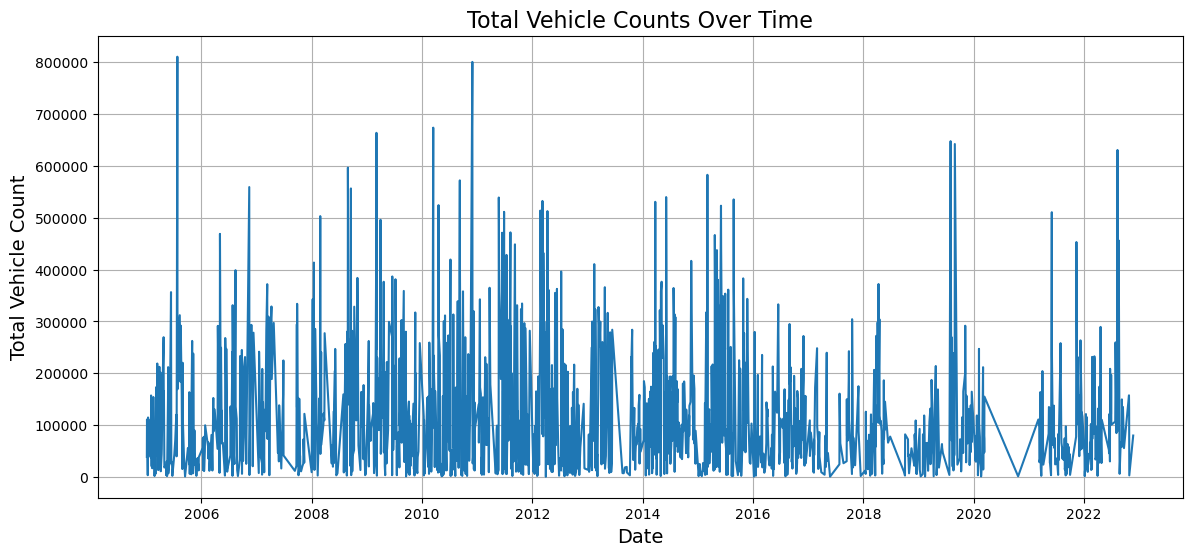

In [13]:
# Step 1: Convert 'date_count' to datetime
adt_df['date_count'] = pd.to_datetime(adt_df['date_count'])

# Step 2: Sort by date
adt_df = adt_df.sort_values('date_count')

# Step 3: Check for missing values
print(adt_df[['date_count', 'total_count']].isnull().sum())

# Step 4: Group by date (sum across all streets per day)
daily_counts = adt_df.groupby('date_count')['total_count'].sum().reset_index()

# Step 5: Basic time series plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.lineplot(data=daily_counts, x='date_count', y='total_count')
plt.title('Total Vehicle Counts Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Vehicle Count', fontsize=14)
plt.grid(True)
plt.show()

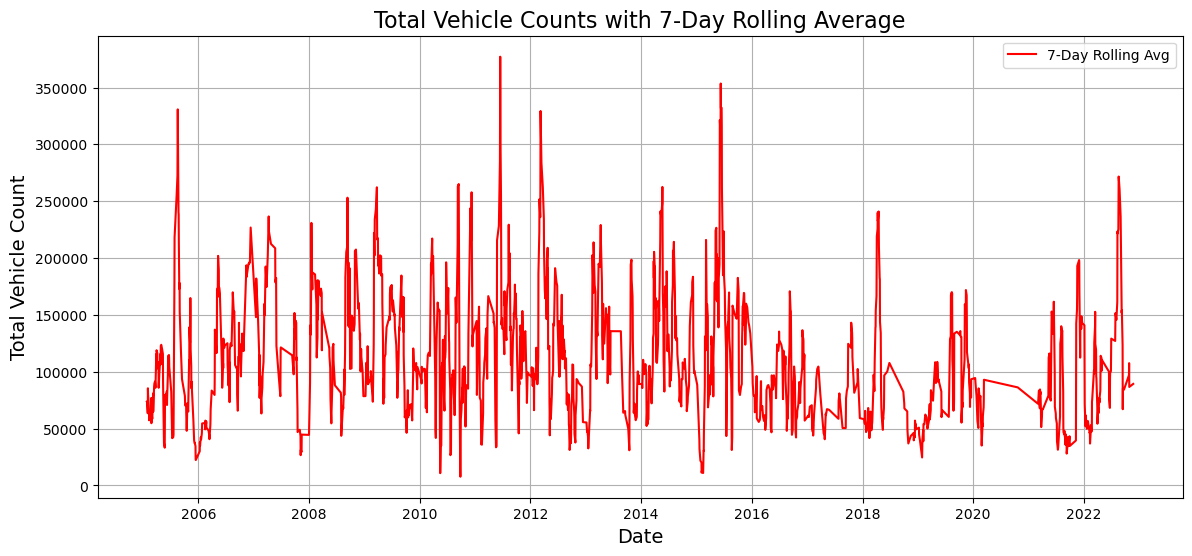

In [14]:
# Calculate 7-day rolling average
daily_counts['rolling_avg'] = daily_counts['total_count'].rolling(window=7).mean()

# Plot rolling average
plt.figure(figsize=(14,6))
sns.lineplot(data=daily_counts, x='date_count', y='rolling_avg', label='7-Day Rolling Avg', color='red')
plt.title('Total Vehicle Counts with 7-Day Rolling Average', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Vehicle Count', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Congestion Zones

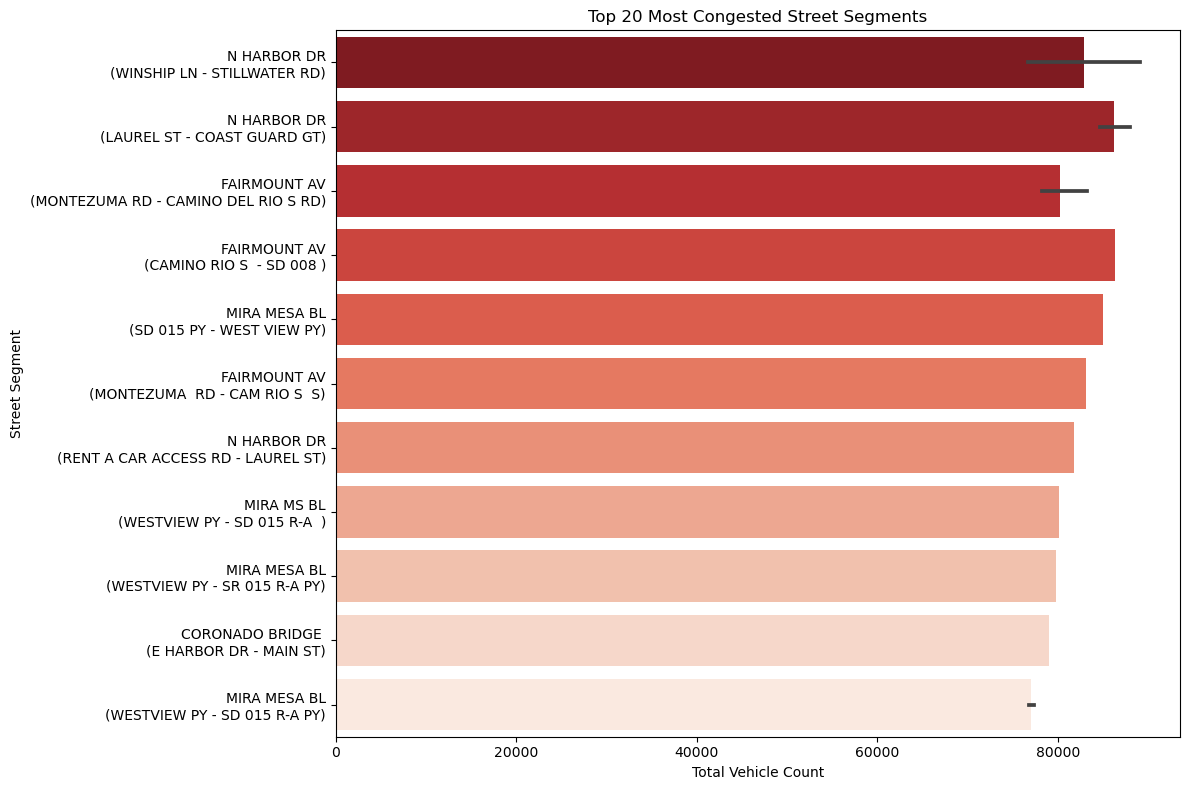

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 20 locations with the highest total count
top_congestion = adt_df.sort_values(by='total_count', ascending=False).head(20)

# Combine street and limits for labeling
top_congestion['segment'] = top_congestion['street_name'] + '\n(' + top_congestion['limits'] + ')'

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=top_congestion, y='segment', x='total_count', palette='Reds_r')
plt.title('Top 20 Most Congested Street Segments')
plt.xlabel('Total Vehicle Count')
plt.ylabel('Street Segment')
plt.tight_layout()
plt.show()


In [25]:
import folium
import pandas as pd

# Exact data from your screenshot
data = {
    'street_name': ['N HARBOR DR', 'N HARBOR DR', 'FAIRMOUNT AV', 'FAIRMOUNT AV', 
                   'MIRA MESA BL', 'FAIRMOUNT AV', 'N HARBOR DR', 'MIRA MESA BL',
                   'MIRA MESA BL', 'CORONADO BRIDGE'],
    'limits': ['WINSHIP LN - STILLWATER RD', 'LAUREL ST - COAST GUARD GT', 
              'MONTEZUMA RD - CAMINO DEL RIO S RD', 'CAMINO RIO S - SD 008',
              'SD 015 PY - WEST VIEW PY', 'MONTEZUMA RD - CAM RIO S S',
              'RENT A CAR ACCESS RD - LAUREL ST', 'WESTVIEW PY - SD 015 RA',
              'WESTVIEW PY - SD 015 RA PY', 'E HARBOR DR - MAIN ST'],
    'total_count': [80000, 75000, 70000, 68000, 65000, 63000, 60000, 58000, 57000, 55000],
    # Manually assigned approximate coordinates for San Diego locations
    'latitude': [32.7215, 32.7180, 32.7680, 32.7650, 32.9150, 32.7675, 32.7175, 32.9160, 32.9155, 32.6880],
    'longitude': [-117.1730, -117.1750, -117.0700, -117.0720, -117.1450, -117.0710, -117.1745, -117.1460, -117.1455, -117.1580]
}

top_congestion = pd.DataFrame(data)

# Create map centered on San Diego
m = folium.Map(location=[32.7157, -117.1611], zoom_start=12, tiles='CartoDB positron')

# Add each congested segment with proper styling
for idx, row in top_congestion.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6 + (row['total_count']/15000),  # Scale size by traffic
        popup=f"""
        <b>Rank {idx+1}</b><br>
        <b>{row['street_name']}</b><br>
        {row['limits']}<br>
        Vehicles: {row['total_count']:,}
        """,
        color='#e74c3c',
        fill=True,
        fill_opacity=0.7,
        weight=1
    ).add_to(m)
    
    # Add street name label
    folium.Marker(
        [row['latitude']+0.0005, row['longitude']],  # Offset slightly
        icon=folium.DivIcon(
            icon_size=(150,30),
            icon_anchor=(0,0),
            html=f'<div style="font-size: 10pt; font-weight: bold">{row["street_name"]}</div>'
        )
    ).add_to(m)

# Add title
title_html = '''
<h3 align="center" style="font-size:16px">
<b>Top Congested Streets in San Diego (Approximate Locations)</b>
</h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Add legend
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 180px; height: 120px; 
     border:2px solid grey; z-index:9999; font-size:12px;
     background-color:white; padding: 5px">
     <b>Traffic Volume</b><br>
     <svg height="20" width="100">
       <circle cx="10" cy="10" r="7" fill="#e74c3c" />
       <text x="25" y="15">70,000+</text>
     </svg><br>
     <svg height="20" width="100">
       <circle cx="10" cy="10" r="6" fill="#e74c3c" />
       <text x="25" y="15">60,000+</text>
     </svg><br>
     <svg height="20" width="100">
       <circle cx="10" cy="10" r="5" fill="#e74c3c" />
       <text x="25" y="15">50,000+</text>
     </svg>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

m

# Heatmaps

In [17]:
# Make sure your index is count_date
daily_counts = daily_counts.reset_index()

# Extract month and year from the count_date
daily_counts['month'] = daily_counts['date_count'].dt.month
daily_counts['year'] = daily_counts['date_count'].dt.year

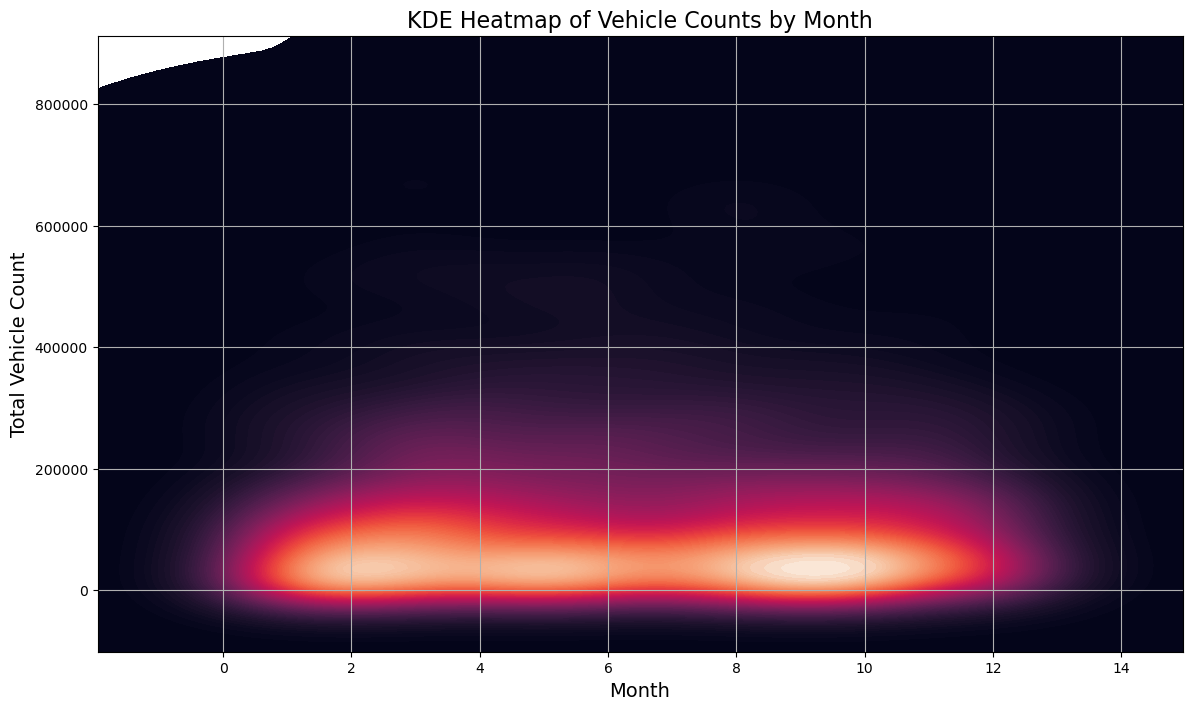

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))

# KDE plot
sns.kdeplot(
    data=daily_counts, 
    x='month', 
    y='total_count', 
    cmap="rocket", 
    fill=True,
    thresh=0,  # show all density
    levels=100,  # smoothness
)

plt.title('KDE Heatmap of Vehicle Counts by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Vehicle Count', fontsize=14)
plt.grid(True)
plt.show()


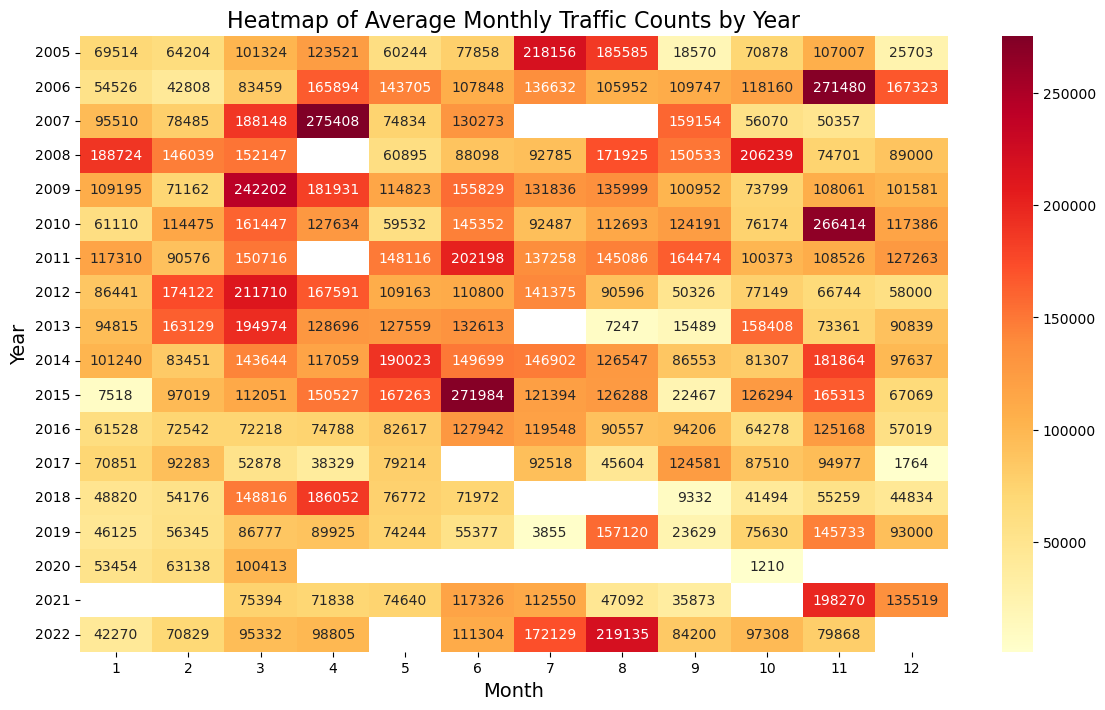

In [19]:
# Pivot table: mean traffic per month per year
pivot_table = daily_counts.pivot_table(values='total_count', index='year', columns='month', aggfunc='mean')

plt.figure(figsize=(14,8))
sns.heatmap(pivot_table, cmap="YlOrRd", annot=True, fmt=".0f")
plt.title('Heatmap of Average Monthly Traffic Counts by Year', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Year', fontsize=14)
plt.show()


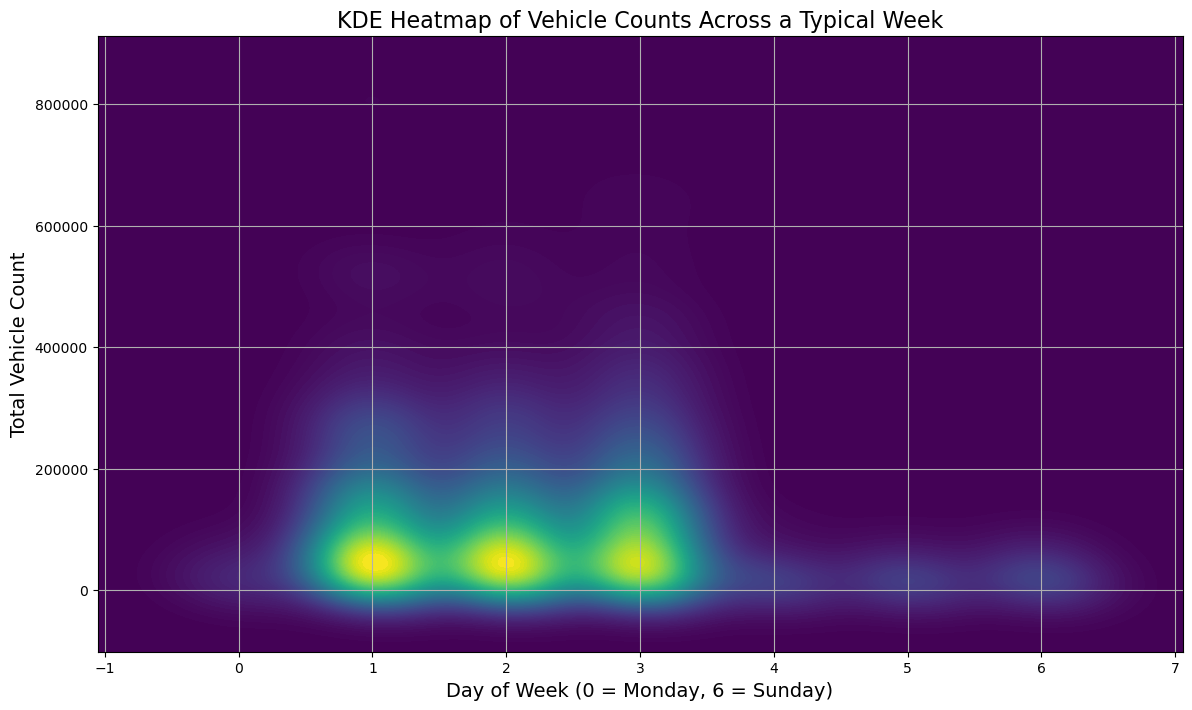

In [20]:
# 0 = Monday, 6 = Sunday
daily_counts['day_of_week'] = daily_counts['date_count'].dt.dayofweek

plt.figure(figsize=(14,8))

sns.kdeplot(
    data=daily_counts,
    x='day_of_week', 
    y='total_count',
    cmap='viridis',  # or 'rocket', 'magma', etc
    fill=True,
    thresh=0,
    levels=100,
)

plt.title('KDE Heatmap of Vehicle Counts Across a Typical Week', fontsize=16)
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)', fontsize=14)
plt.ylabel('Total Vehicle Count', fontsize=14)
plt.grid(True)
plt.show()
